In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18
...,...,...,...
19122,REITs vs. Stocks: What Does the Data Say?,2024-03-04,5130.95
19123,"Nasdaq Index, Dow Jones, S&P 500 News: Futures...",2024-03-04,5130.95
19124,"Nasdaq 100, Dow Jones, S&P 500 News: Cautious ...",2024-03-04,5130.95
19125,"Bank of America boosts S&P 500 target to 5,400...",2024-03-04,5130.95


In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

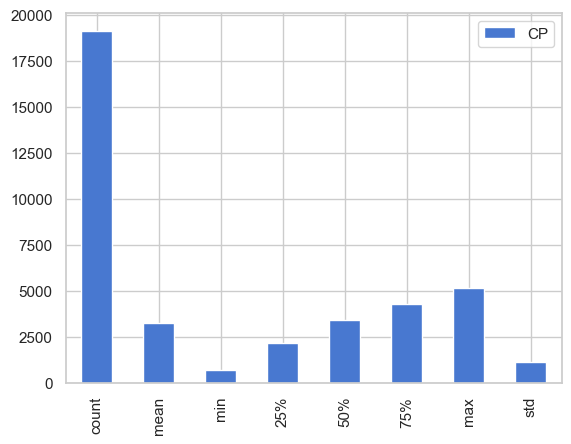

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

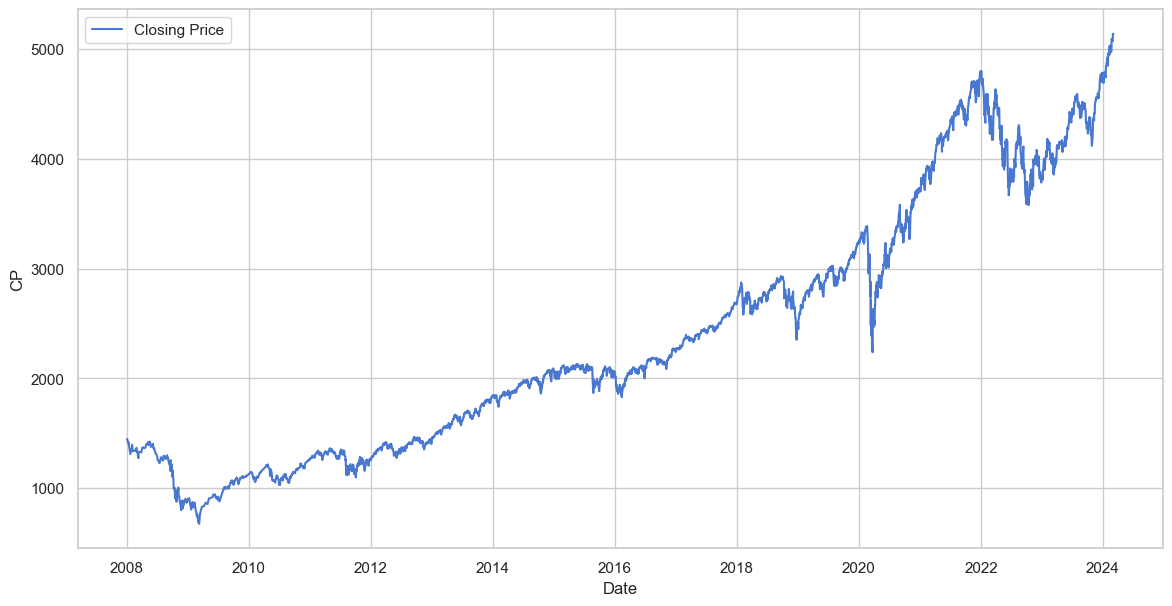

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


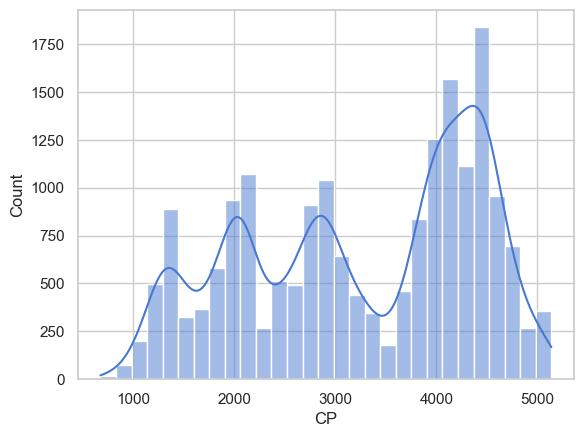

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = 10000

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)  # Limit to 1000 rows for testing
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 10000/10000 [08:13<00:00, 20.26it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
# Define volatility period
volatility_period = 7  # You can change this to any n-day period you want

# Daily average sentiment
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
daily_sentiment['n_day_sent_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=volatility_period).std()

print(daily_sentiment)


           Date  avg_sentiment_score_a_day  n_day_sent_volatility
0    2008-01-02                   0.268444                    NaN
1    2008-01-03                  -0.787446                    NaN
2    2008-01-07                  -0.338189                    NaN
3    2008-01-09                   0.464082                    NaN
4    2008-01-10                  -0.367122                    NaN
...         ...                        ...                    ...
2731 2021-01-21                   0.253463               0.150058
2732 2021-01-25                   0.054363               0.180519
2733 2021-01-26                   0.626690               0.213176
2734 2021-01-27                   0.746452               0.262447
2735 2021-01-28                   0.689250               0.280579

[2736 rows x 3 columns]


## Prepare market data

In [ ]:
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.8, close_col="CP"):
    """
    Adds a binary label indicating a future crash (within 'look_ahead_days')
    where future price is less than drop_threshold * current price.
    
    Parameters:
        df (pd.DataFrame): Your market data with a 'Close' column
        look_ahead_days (int): Days to look ahead for crash (number of trading days in a year approximately 252 days)
        drop_threshold (float): Threshold below current price to define crash
        close_col (str): Column name for close price (default: 'Close')
        
    Returns:
        pd.DataFrame: Original DataFrame with 'future_crash' column
    """
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
look_ahead_days = 252
drop_threshold = 0.85

# Assuming df_merged has your data with 'Close' price
sp500_headlines_2008_2024_test_labeled = add_future_crash_label(sp500_headlines_2008_2024_test, look_ahead_days, drop_threshold)

# Now df_labeled includes a 'future_crash' column
sp500_headlines_2008_2024_test_labeled[['Date', 'CP', 'future_close', 'future_crash']]


,Date,CP,future_close,future_crash
0,2008-01-02,1447.16,1126.42,1
1,2008-01-02,1447.16,1126.42,1
2,2008-01-02,1447.16,1136.52,1
3,2008-01-03,1447.16,1136.52,1
4,2008-01-07,1416.18,1136.52,1
...,...,...,...,...
9995,2021-01-26,3849.62,NaN,0
9996,2021-01-26,3849.62,NaN,0
9997,2021-01-27,3750.77,NaN,0
9998,2021-01-27,3750.77,NaN,0


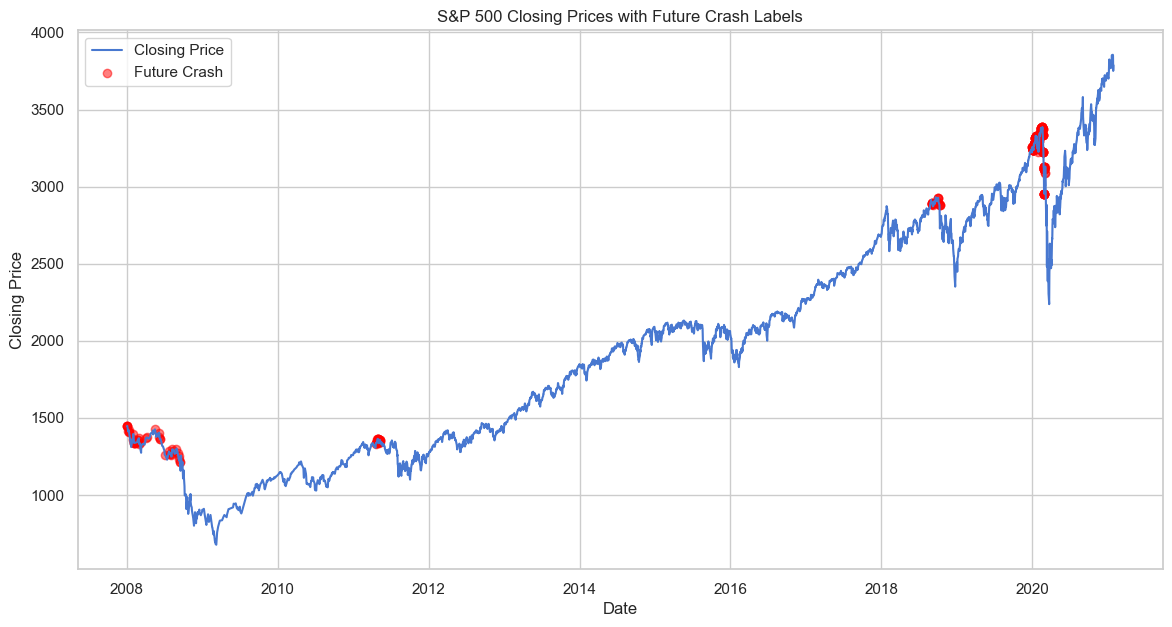

In [28]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024_test_labeled, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_test_labeled[sp500_headlines_2008_2024_test_labeled['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_test_labeled[sp500_headlines_2008_2024_test_labeled['future_crash'] == 1]['CP'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [12]:
# Calculate daily returns
sp500_headlines_2008_2024_test['daily_return'] = sp500_headlines_2008_2024_test['CP'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_data = sp500_headlines_2008_2024_test[['Date', 'CP', 'daily_return']].copy()
market_data['Date'] = pd.to_datetime(market_data['Date'])

market_data

,Date,CP,daily_return
0,2008-01-02,1447.16,NaN
1,2008-01-02,1447.16,0.000000
2,2008-01-02,1447.16,0.000000
3,2008-01-03,1447.16,0.000000
4,2008-01-07,1416.18,-2.140745
...,...,...,...
9995,2021-01-26,3849.62,0.000000
9996,2021-01-26,3849.62,0.000000
9997,2021-01-27,3750.77,-2.567786
9998,2021-01-27,3750.77,0.000000


In [13]:
# Calculate n-day returns
def calculate_n_day_returns(data, n):
    data['n_day_market_return'] = data['CP'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_data = calculate_n_day_returns(market_data, volatility_period)
market_data

,Date,CP,daily_return,n_day_market_return
0,2008-01-02,1447.16,NaN,NaN
1,2008-01-02,1447.16,0.000000,NaN
2,2008-01-02,1447.16,0.000000,NaN
3,2008-01-03,1447.16,0.000000,NaN
4,2008-01-07,1416.18,-2.140745,NaN
...,...,...,...,...
9995,2021-01-26,3849.62,0.000000,-0.148884
9996,2021-01-26,3849.62,0.000000,-0.148884
9997,2021-01-27,3750.77,-2.567786,-2.712847
9998,2021-01-27,3750.77,0.000000,-2.712847


In [14]:
# Calculate n-day log returns
def calculate_n_day_log_returns(data, n):
    data['n_day_log_return'] = np.log(data['CP'] / data['CP'].shift(n))
    return data

market_data = calculate_n_day_log_returns(market_data, volatility_period)
market_data

,Date,CP,daily_return,n_day_market_return,n_day_log_return
0,2008-01-02,1447.16,NaN,NaN,NaN
1,2008-01-02,1447.16,0.000000,NaN,NaN
2,2008-01-02,1447.16,0.000000,NaN,NaN
3,2008-01-03,1447.16,0.000000,NaN,NaN
4,2008-01-07,1416.18,-2.140745,NaN,NaN
...,...,...,...,...,...
9995,2021-01-26,3849.62,0.000000,-0.148884,-0.001490
9996,2021-01-26,3849.62,0.000000,-0.148884,-0.001490
9997,2021-01-27,3750.77,-2.567786,-2.712847,-0.027503
9998,2021-01-27,3750.77,0.000000,-2.712847,-0.027503


In [15]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, n):
    data['n_day_market_volatility'] = data['n_day_log_return'].rolling(window=n).std()  # Standard deviation of closing prices
    return data

market_data = calculate_n_day_volatility(market_data, volatility_period)
market_data

,Date,CP,daily_return,n_day_market_return,n_day_log_return,n_day_market_volatility
0,2008-01-02,1447.16,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,0.000000,NaN,NaN,NaN
2,2008-01-02,1447.16,0.000000,NaN,NaN,NaN
3,2008-01-03,1447.16,0.000000,NaN,NaN,NaN
4,2008-01-07,1416.18,-2.140745,NaN,NaN,NaN
...,...,...,...,...,...,...
9995,2021-01-26,3849.62,0.000000,-0.148884,-0.001490,0.000986
9996,2021-01-26,3849.62,0.000000,-0.148884,-0.001490,0.000939
9997,2021-01-27,3750.77,-2.567786,-2.712847,-0.027503,0.010065
9998,2021-01-27,3750.77,0.000000,-2.712847,-0.027503,0.012812


## Define dynamic crash label

In [ ]:
k = 2  # You can adjust this multiplier (e.g., 2 times the rolling volatility)

# Avoid NaN during initial periods
market_data['crash_threshold'] = -k * market_data['n_day_market_volatility']

# Define crash label (1 = crash, 0 = no crash)
market_data['crash_label'] = (market_data['n_day_market_return'] < market_data['crash_threshold']).astype(int)

# q = 0.05  # 5% worst returns
# threshold = market_data['n_day_market_return'].quantile(q)
# market_data['crash_label'] = (market_data['n_day_market_return'] <= threshold).astype(int)

print(len(market_data[market_data['crash_label'] == 1]))

3865


In [17]:
# Merge market data with daily sentiment
market_sentiment_data = market_data.merge(daily_sentiment, on='Date', how='left')
market_sentiment_data

,Date,CP,daily_return,n_day_market_return,n_day_log_return,n_day_market_volatility,crash_threshold,crash_label,avg_sentiment_score_a_day,n_day_sent_volatility
0,2008-01-02,1447.16,NaN,NaN,NaN,NaN,NaN,0,0.268444,NaN
1,2008-01-02,1447.16,0.000000,NaN,NaN,NaN,NaN,0,0.268444,NaN
2,2008-01-02,1447.16,0.000000,NaN,NaN,NaN,NaN,0,0.268444,NaN
3,2008-01-03,1447.16,0.000000,NaN,NaN,NaN,NaN,0,-0.787446,NaN
4,2008-01-07,1416.18,-2.140745,NaN,NaN,NaN,NaN,0,-0.338189,NaN
...,...,...,...,...,...,...,...,...,...,...
9995,2021-01-26,3849.62,0.000000,-0.148884,-0.001490,0.000986,-0.001971,1,0.626690,0.213176
9996,2021-01-26,3849.62,0.000000,-0.148884,-0.001490,0.000939,-0.001879,1,0.626690,0.213176
9997,2021-01-27,3750.77,-2.567786,-2.712847,-0.027503,0.010065,-0.020131,1,0.746452,0.262447
9998,2021-01-27,3750.77,0.000000,-2.712847,-0.027503,0.012812,-0.025624,1,0.746452,0.262447


In [18]:
model_data = market_sentiment_data[['Date', 
                         'avg_sentiment_score_a_day', 
                         'n_day_sent_volatility', 
                         'n_day_market_volatility', 
                         'crash_label']]

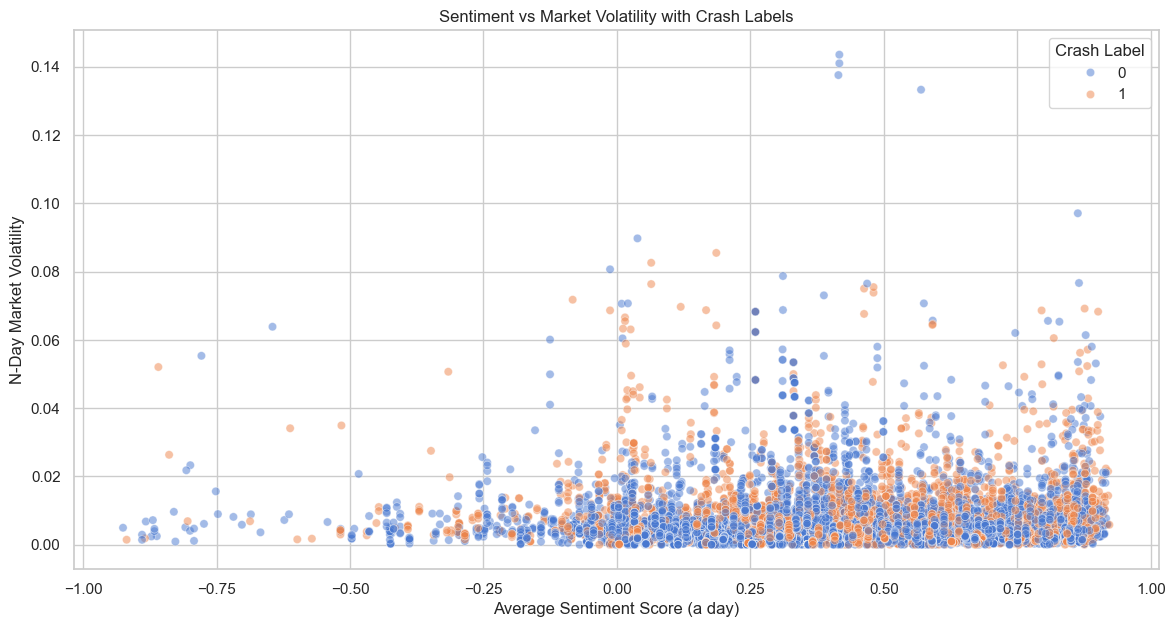

In [19]:
# Plot relationships between sentiment, matket volatility, and crash labels
plt.figure(figsize=(14, 7))
sns.scatterplot(x='avg_sentiment_score_a_day', y='n_day_market_volatility', hue='crash_label', data=model_data, alpha=0.5)
plt.title('Sentiment vs Market Volatility with Crash Labels')
plt.xlabel('Average Sentiment Score (a day)')
plt.ylabel('N-Day Market Volatility')
plt.legend(title='Crash Label')
plt.show()